<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
house = pd.read_csv('./housing.csv')

In [3]:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
house.shape

(1460, 81)

In [6]:
house['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [7]:
# Select only residential houses in the dataset.

In [8]:
house = house[house['MSZoning'] != 'C (all)']

In [9]:
house.shape

(1450, 81)

In [10]:
# Fixed features to consider:
# MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,
# BldgType,HouseStyle,MasVnrArea,BsmtQual,1BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,
# GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageType,
# GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea

In [11]:
house[['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']].head()

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
0,706,0,150,856
1,978,0,284,1262
2,486,0,434,920
3,216,0,540,756
4,655,0,490,1145


In [12]:
# Since feature TotalBsmtSF is the sum of features 1BsmtFinSF1, BsmtFinSF2 and BsmtUnfSF, just consider feature 
# TotalBsmtSF.

In [13]:
house[['1stFlrSF','2ndFlrSF','GrLivArea']].head()

,1stFlrSF,2ndFlrSF,GrLivArea
0,856,854,1710
1,1262,0,1262
2,920,866,1786
3,961,756,1717
4,1145,1053,2198


In [14]:
# Since feature GrLivArea is the sum of features 1stFlrSF and 2ndFlrSF, just consider feature GrLivArea.

In [15]:
house[['GrLivArea','TotRmsAbvGrd']].corr()

,GrLivArea,TotRmsAbvGrd
GrLivArea,1.000000,0.825183
TotRmsAbvGrd,0.825183,1.000000


In [16]:
# Since features GrLivArea and TotRmsAbvGrd are highly correlated, just consider feature GrLivArea.

In [17]:
house[['GarageCars', 'GarageArea']].corr()

,GarageCars,GarageArea
GarageCars,1.000000,0.883009
GarageArea,0.883009,1.000000


In [18]:
# Since features GarageCars and GarageArea are highly correlated, just consider feature GarageArea.

In [19]:
df = house[['YrSold','SalePrice','MSSubClass','MSZoning','LotFrontage','LotArea','LotShape','LandContour','LotConfig','LandSlope',
           'Neighborhood','Condition1','Condition2','BldgType','HouseStyle','MasVnrArea','BsmtQual','TotalBsmtSF',
           'LowQualFinSF','GrLivArea','BedroomAbvGr','KitchenAbvGr','Fireplaces','GarageType','GarageArea',
           'WoodDeckSF','PoolArea']]

In [20]:
# Create new feature TotalFullBath, which is the sum of features BsmtFullBath and FullBath.

In [21]:
df['TotalFullBath'] = house['BsmtFullBath'] + house['FullBath']

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
df['TotalFullBath'].value_counts()

2    749
1    362
3    319
4     18
6      1
0      1
Name: TotalFullBath, dtype: int64

In [23]:
# Create new feature TotalFullBath, which is the sum of features BsmtHalfBath and HalfBath.

In [24]:
df['TotalHalfBath'] = house['BsmtHalfBath'] + house['HalfBath']

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
df['TotalHalfBath'].value_counts()

0    847
1    570
2     29
3      3
4      1
Name: TotalHalfBath, dtype: int64

In [26]:
# Create new feature PorchArea, which is the sum of features OpenPorchSF, EnclosedPorch, 3SsnPorch and ScreenPorch.

In [27]:
df['PorchArea'] = house['OpenPorchSF'] + house['EnclosedPorch'] + house['3SsnPorch'] + house['ScreenPorch']

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [28]:
df['PorchArea'].value_counts().head(10)

0      456
36      27
40      20
48      19
45      18
39      15
24      14
96      14
20      14
120     13
Name: PorchArea, dtype: int64

In [29]:
# Since feature MSSubClass contains similar information to features BldgType and HouseStyle, remove feature MSSubClass.

In [30]:
df.drop(['MSSubClass'], axis = 1, inplace = True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [31]:
df.dtypes

YrSold             int64
SalePrice          int64
MSZoning          object
LotFrontage      float64
LotArea            int64
LotShape          object
LandContour       object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
MasVnrArea       float64
BsmtQual          object
TotalBsmtSF        int64
LowQualFinSF       int64
GrLivArea          int64
BedroomAbvGr       int64
KitchenAbvGr       int64
Fireplaces         int64
GarageType        object
GarageArea         int64
WoodDeckSF         int64
PoolArea           int64
TotalFullBath      int64
TotalHalfBath      int64
PorchArea          int64
dtype: object

In [32]:
# Check variability of features.

In [33]:
df['Condition2'].value_counts()

Norm      1436
Feedr        5
PosN         2
Artery       2
RRNn         2
RRAn         1
RRAe         1
PosA         1
Name: Condition2, dtype: int64

In [34]:
df['LowQualFinSF'].value_counts().head(10)

0      1425
80        3
360       2
371       1
53        1
120       1
144       1
156       1
205       1
232       1
Name: LowQualFinSF, dtype: int64

In [35]:
df['PoolArea'].value_counts()

0      1443
738       1
648       1
576       1
555       1
519       1
512       1
480       1
Name: PoolArea, dtype: int64

In [36]:
# Remove features Condition2, LowQualFinSF and PoolArea due to low variability.

In [37]:
df.drop(['Condition2','LowQualFinSF','PoolArea'], axis = 1, inplace = True)

In [38]:
df.describe()

,YrSold,SalePrice,LotFrontage,LotArea,MasVnrArea,TotalBsmtSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageArea,WoodDeckSF,TotalFullBath,TotalHalfBath,PorchArea
count,1450.000000,1450.000000,1191.000000,1450.000000,1442.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000
mean,2007.812414,181654.942069,70.052897,10523.831724,104.404300,1059.408966,1517.698621,2.870345,1.046207,0.616552,473.277931,94.826897,1.996552,0.442069,86.604138
std,1.326321,79176.485241,24.301013,10012.185355,181.486539,439.207322,525.154207,0.814645,0.219643,0.644991,212.687621,125.560863,0.730383,0.554568,104.368794
min,2006.000000,37900.000000,21.000000,1300.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2007.000000,130000.000000,59.000000,7544.500000,0.000000,796.000000,1131.250000,2.000000,1.000000,0.000000,336.000000,0.000000,1.250000,0.000000,0.000000
50%,2008.000000,163945.000000,70.000000,9496.000000,0.000000,992.000000,1466.000000,3.000000,1.000000,1.000000,480.000000,0.000000,2.000000,0.000000,48.000000
75%,2009.000000,214000.000000,80.000000,11613.500000,166.750000,1301.500000,1779.000000,3.000000,1.000000,1.000000,576.000000,168.000000,2.000000,1.000000,135.000000
max,2010.000000,755000.000000,313.000000,215245.000000,1600.000000,6110.000000,5642.000000,8.000000,3.000000,3.000000,1418.000000,857.000000,6.000000,4.000000,1027.000000


In [39]:
# Check multicollinearity of numerical features. 

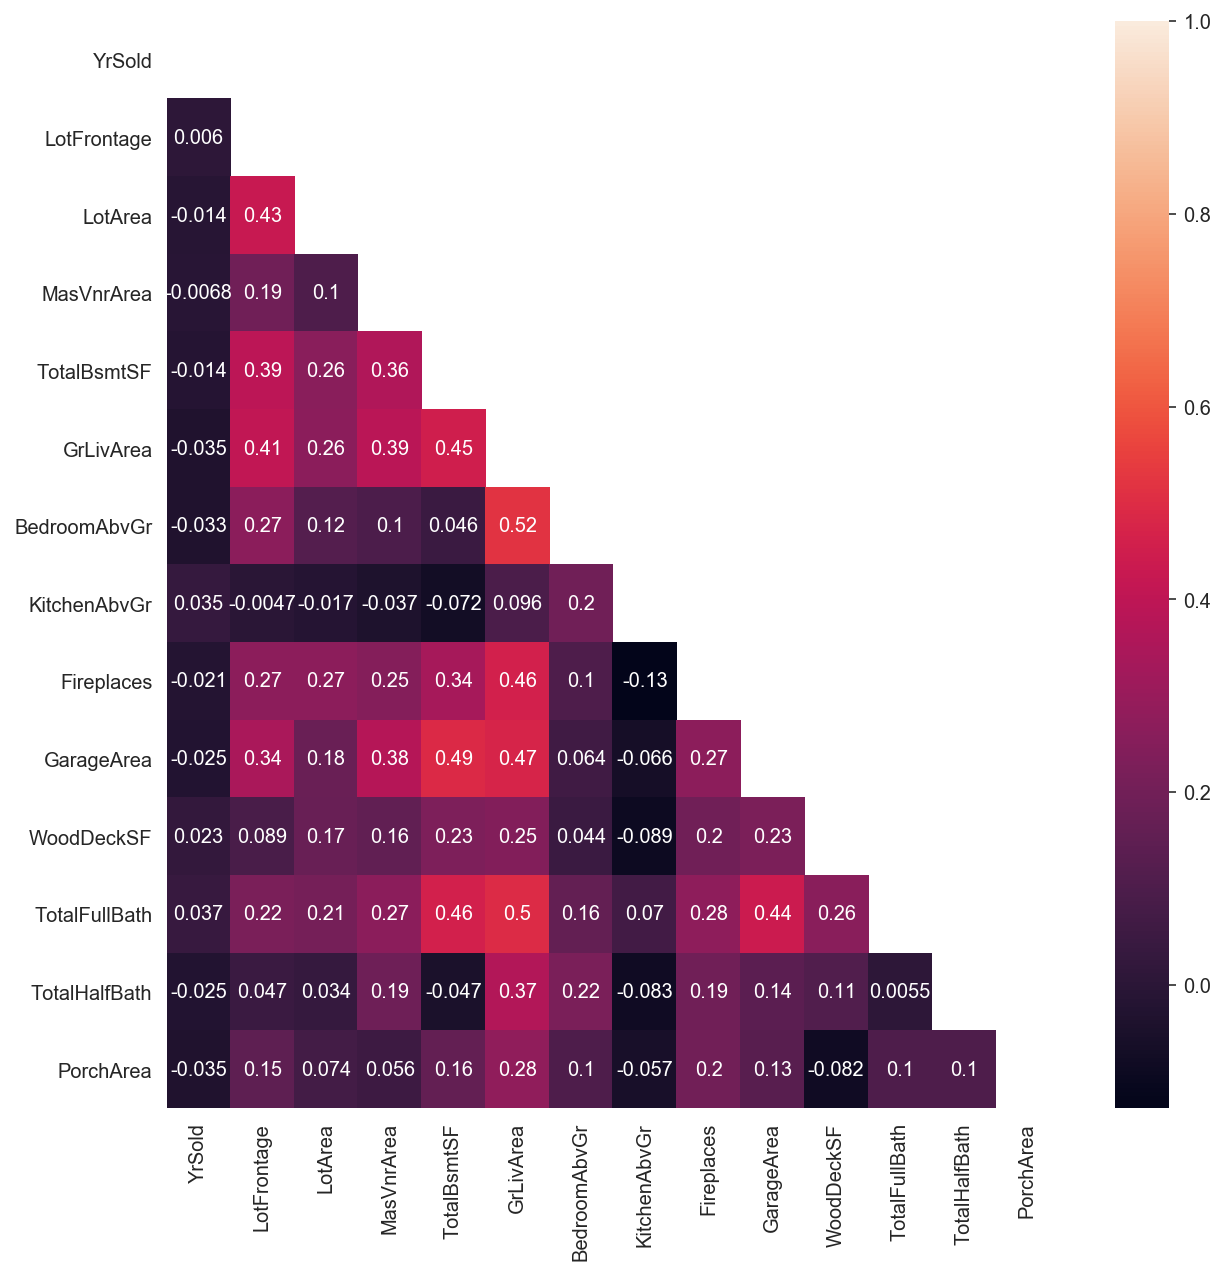

In [40]:
fig = plt.figure(figsize = (10,10))
mask = np.zeros_like(df.drop(['SalePrice'],axis = 1).corr(),dtype = np.bool)
mask[np.triu_indices_from(mask)] = True 
sns.heatmap(df.drop(['SalePrice'],axis = 1).corr(),annot = True,mask = mask)
plt.show()

In [41]:
df.isnull().sum()

YrSold             0
SalePrice          0
MSZoning           0
LotFrontage      259
LotArea            0
LotShape           0
LandContour        0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
BldgType           0
HouseStyle         0
MasVnrArea         8
BsmtQual          37
TotalBsmtSF        0
GrLivArea          0
BedroomAbvGr       0
KitchenAbvGr       0
Fireplaces         0
GarageType        79
GarageArea         0
WoodDeckSF         0
TotalFullBath      0
TotalHalfBath      0
PorchArea          0
dtype: int64

In [42]:
df[['LotFrontage', 'SalePrice']].corr()

,LotFrontage,SalePrice
LotFrontage,1.000000,0.354848
SalePrice,0.354848,1.000000


In [43]:
# Since feature LotFrontage and target SalePrice are not highly correlated, remove feature LotFrontage.

In [44]:
df.drop(['LotFrontage'],axis = 1, inplace = True)

In [45]:
# Check feature MasVnrType for feature MasVnrArea with NaN values.

In [46]:
df[df['MasVnrArea'].isnull()]

,YrSold,SalePrice,MSZoning,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,GrLivArea,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageType,GarageArea,WoodDeckSF,TotalFullBath,TotalHalfBath,PorchArea
234,2010,216500,RL,7851,Reg,Lvl,Inside,Gtl,Gilbert,Norm,...,1960,4,1,2,BuiltIn,440,288,3,1,48
529,2007,200624,RL,32668,IR1,Lvl,CulDSac,Gtl,Crawfor,Norm,...,2515,4,2,2,Attchd,484,0,4,0,200
650,2008,205950,FV,8125,Reg,Lvl,Inside,Gtl,Somerst,Norm,...,1665,3,1,0,Attchd,562,0,2,1,0
936,2009,184900,RL,10083,Reg,Lvl,Inside,Gtl,SawyerW,Norm,...,1200,2,1,0,Attchd,555,0,3,0,41
973,2008,182000,FV,11639,Reg,Lvl,Corner,Gtl,Somerst,Norm,...,1428,3,1,0,Attchd,480,0,2,0,120
977,2007,199900,FV,4274,IR1,Lvl,Inside,Gtl,Somerst,Norm,...,1241,1,1,0,Attchd,569,0,2,1,116
1243,2006,465000,RL,13891,Reg,Lvl,Inside,Gtl,NridgHt,Norm,...,2076,2,1,1,Attchd,850,216,3,1,229
1278,2008,237000,RL,9473,Reg,Lvl,Inside,Gtl,CollgCr,Norm,...,2031,3,1,1,Attchd,577,0,3,1,211


In [47]:
house.loc[[234,529,650,936,973,977,1243,1278],'MasVnrType']

234     NaN
529     NaN
650     NaN
936     NaN
973     NaN
977     NaN
1243    NaN
1278    NaN
Name: MasVnrType, dtype: object

In [48]:
df['MasVnrArea'].value_counts().head()

0.0      851
72.0       8
180.0      8
108.0      8
120.0      7
Name: MasVnrArea, dtype: int64

In [49]:
# For feature MasVnrArea, impute NaN values with 0, the modal value of the feature.

In [50]:
df.loc[:,'MasVnrArea'] = df.loc[:,'MasVnrArea'].fillna(0) 

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [51]:
# For feature BsmtQual, houses with no basement have NaN values. Apply one hot encoding.

In [52]:
# For feature GarageType, houses with no garage have NaN values. Apply one hot encoding.

In [53]:
df.isnull().sum()

YrSold            0
SalePrice         0
MSZoning          0
LotArea           0
LotShape          0
LandContour       0
LotConfig         0
LandSlope         0
Neighborhood      0
Condition1        0
BldgType          0
HouseStyle        0
MasVnrArea        0
BsmtQual         37
TotalBsmtSF       0
GrLivArea         0
BedroomAbvGr      0
KitchenAbvGr      0
Fireplaces        0
GarageType       79
GarageArea        0
WoodDeckSF        0
TotalFullBath     0
TotalHalfBath     0
PorchArea         0
dtype: int64

In [54]:
dummy = pd.get_dummies(df[['MSZoning','LotShape','LandContour','LotConfig','LandSlope','Neighborhood','Condition1',
                           'BldgType','HouseStyle']])
dummy1 = pd.get_dummies(df[['BsmtQual']],dummy_na = True)
dummy2 = pd.get_dummies(df[['GarageType']],dummy_na = True)

In [55]:
df = pd.concat([df,dummy], axis = 1)
df = pd.concat([df,dummy1], axis = 1)
df = pd.concat([df,dummy2], axis = 1)
df.drop(['MSZoning','LotShape','LandContour','LotConfig','LandSlope','Neighborhood','Condition1','BldgType',
         'HouseStyle','BsmtQual','GarageType','GarageType_nan'], axis = 1, inplace = True)

In [56]:
X_train = df[df['YrSold'] != 2010].iloc[:,2:]
y_train = df[df['YrSold'] != 2010]['SalePrice']

X_test = df[df['YrSold'] == 2010].iloc[:,2:]
y_test = df[df['YrSold'] == 2010]['SalePrice']

In [57]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train.iloc[:,:12] = ss.fit_transform(X_train.iloc[:,:12]) 
X_test.iloc[:,:12] = ss.transform(X_test.iloc[:,:12])

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [58]:
# Try Lasso

In [59]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.model_selection import cross_val_score

lasso_alpha = np.linspace(50, 100, 500)
optimal_lasso = LassoCV(alphas = lasso_alpha, cv = 5, verbose = 1)
optimal_lasso.fit(X_train, y_train)

print('Best alpha:', optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Best alpha: 74.749498997996


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


In [60]:
lasso = Lasso(alpha = optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, X_train, y_train, cv = 5)

print('Scores:', lasso_scores)
print('Mean score:', np.mean(lasso_scores))
print('Standard deviation of scores:', np.std(lasso_scores))

Scores: [0.86298902 0.81074873 0.82706049 0.82800744 0.67510354]
Mean score: 0.8007818445945389
Standard deviation of scores: 0.0651089987723127


In [61]:
# Try Ridge

In [62]:
ridge_alpha = np.linspace(1, 10, 100)
optimal_ridge = RidgeCV(alphas = ridge_alpha, cv = 5)
optimal_ridge.fit(X_train, y_train)

print('Best alpha:', optimal_ridge.alpha_)

Best alpha: 6.0


In [63]:
ridge = Ridge(alpha = optimal_ridge.alpha_)
ridge_scores = cross_val_score(ridge, X_train, y_train, cv = 5)

print('Scores:', ridge_scores)
print('Mean score:', np.mean(ridge_scores))
print('Standard deviation of scores:', np.std(ridge_scores))

Scores: [0.86812658 0.81249379 0.82677525 0.83058097 0.66172574]
Mean score: 0.799940465849508
Standard deviation of scores: 0.07151110074138456


In [64]:
# Lasso model is choosen as it has a higher mean score and a lower standard deviation of scores.

In [65]:
lasso.fit(X_train, y_train)
score = lasso.score(X_test, y_test)

print('R2 score:', score)

R2 score: 0.857051597468994


In [66]:
lasso.coef_

array([ 3.30980479e+03,  2.44723771e+03,  4.28571538e+03,  2.94187896e+04,
       -3.03374243e+03, -5.40258474e+03,  4.65788997e+03,  7.00523200e+03,
        2.20920528e+03,  9.53983654e+03,  4.25410639e+03,  1.81948956e+03,
       -0.00000000e+00,  0.00000000e+00,  1.11914436e+03, -2.11612937e+03,
        2.96830782e+00,  1.21342435e+04, -2.25747975e+04, -6.40401265e-01,
       -1.51535687e+04,  1.11206416e+04,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  9.45063070e+03, -6.79735434e+03, -0.00000000e+00,
        2.45022819e+03,  0.00000000e+00,  3.34305458e+03, -9.28755282e+03,
        1.00228571e+04, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -4.01088032e+03,  7.17871459e+03,  1.35586800e+04, -2.14090296e+04,
       -0.00000000e+00, -5.94763132e+03, -7.67202338e+03, -1.38124361e+04,
       -9.29843524e+03,  0.00000000e+00, -1.02031074e+04,  6.01041035e+04,
        5.07030364e+04, -1.12253966e+04, -1.21259986e+04, -9.71827217e+03,
        1.28622288e+03,  

In [67]:
df1 = pd.DataFrame(lasso.coef_, index = X_train.columns, columns = ['coef'])
df1['abs_coef'] = np.abs(lasso.coef_)
df1.sort_values(by = 'abs_coef', ascending = False).head(10)

,coef,abs_coef
Neighborhood_NoRidge,60104.103532,60104.103532
Neighborhood_StoneBr,58030.082051,58030.082051
BsmtQual_Ex,55645.020835,55645.020835
Neighborhood_NridgHt,50703.036437,50703.036437
GrLivArea,29418.789607,29418.789607
Neighborhood_Somerst,28308.287411,28308.287411
Neighborhood_Veenker,25337.089344,25337.089344
LotShape_IR3,-22574.797505,22574.797505
Neighborhood_Edwards,-21409.029574,21409.029574
BldgType_Twnhs,-18690.167814,18690.167814


In [68]:
# Top 10 estimates of price:
# Houses in neighbourhoods Northridge, Stone Brook, Northridge Heights, Somerset and Veenker are more expensive.
# Houses with excellent basement height and greater above ground living area square feet are also more expensive.
# Houses that have irregular property shape, in neighbourhood Edwards and are Townhouse are less expensive.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [69]:
# Update fixed features that estimate price for use in the next model.

In [70]:
df1[df1['abs_coef'] < 1000].index

Index(['MSZoning_FV', 'MSZoning_RH', 'LotShape_IR1', 'LotShape_Reg',
       'LandContour_Low', 'LandContour_Lvl', 'LotConfig_Corner',
       'LotConfig_FR3', 'LandSlope_Gtl', 'Neighborhood_Blueste',
       'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_Gilbert',
       'Neighborhood_NPkVill', 'Neighborhood_Timber', 'Condition1_Artery',
       'Condition1_PosA', 'Condition1_RRAe', 'Condition1_RRAn',
       'Condition1_RRNe', 'Condition1_RRNn', 'BldgType_2fmCon',
       'BldgType_Duplex', 'HouseStyle_1.5Unf', 'HouseStyle_2.5Fin',
       'HouseStyle_2.5Unf', 'HouseStyle_SLvl', 'BsmtQual_TA', 'BsmtQual_nan',
       'GarageType_Basment'],
      dtype='object')

In [71]:
new_X_train = X_train.drop(['MSZoning_FV', 'MSZoning_RH', 'LotShape_IR1', 'LotShape_Reg', 'LandContour_Low', 
                            'LandContour_Lvl', 'LotConfig_Corner', 'LotConfig_FR3', 'LandSlope_Gtl',
                            'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide',
                            'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'Neighborhood_Timber',
                            'Condition1_Artery', 'Condition1_PosA', 'Condition1_RRAe', 'Condition1_RRAn',
                            'Condition1_RRNe', 'Condition1_RRNn', 'BldgType_2fmCon', 'BldgType_Duplex', 
                            'HouseStyle_1.5Unf', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'HouseStyle_SLvl', 
                            'BsmtQual_TA', 'BsmtQual_nan', 'GarageType_Basment'], axis = 1)

In [72]:
new_X_test = X_test.drop(['MSZoning_FV', 'MSZoning_RH', 'LotShape_IR1', 'LotShape_Reg', 'LandContour_Low', 
                          'LandContour_Lvl', 'LotConfig_Corner', 'LotConfig_FR3', 'LandSlope_Gtl',
                          'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide',
                          'Neighborhood_Gilbert', 'Neighborhood_NPkVill', 'Neighborhood_Timber',
                          'Condition1_Artery', 'Condition1_PosA', 'Condition1_RRAe', 'Condition1_RRAn',
                          'Condition1_RRNe', 'Condition1_RRNn', 'BldgType_2fmCon', 'BldgType_Duplex', 
                          'HouseStyle_1.5Unf', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'HouseStyle_SLvl', 
                          'BsmtQual_TA', 'BsmtQual_nan', 'GarageType_Basment'], axis = 1)

In [73]:
# Renovate-able features to consider:
# Utilities,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,
# Foundation,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual
# Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,Fence,MiscFeature

In [74]:
# Check variability of features.

In [75]:
house['Utilities'].value_counts()

AllPub    1449
NoSeWa       1
Name: Utilities, dtype: int64

In [76]:
house['RoofMatl'].value_counts()

CompShg    1424
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
ClyTile       1
Roll          1
Membran       1
Name: RoofMatl, dtype: int64

In [77]:
house['ExterCond'].value_counts()

TA    1275
Gd     145
Fa      26
Ex       3
Po       1
Name: ExterCond, dtype: int64

In [78]:
house['BsmtCond'].value_counts()

TA    1303
Gd      65
Fa      43
Po       2
Name: BsmtCond, dtype: int64

In [79]:
house['BsmtFinType2'].value_counts()

Unf    1246
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

In [80]:
house['Heating'].value_counts()

GasA     1419
GasW       17
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

In [81]:
house['CentralAir'].value_counts()

Y    1361
N      89
Name: CentralAir, dtype: int64

In [82]:
house['Electrical'].value_counts()

SBrkr    1328
FuseA      90
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [83]:
house['Functional'].value_counts()

Typ     1350
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

In [84]:
house['GarageQual'].value_counts()

TA    1303
Fa      48
Gd      14
Po       3
Ex       3
Name: GarageQual, dtype: int64

In [85]:
house['GarageCond'].value_counts()

TA    1319
Fa      34
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64

In [86]:
house['PavedDrive'].value_counts()

Y    1335
N      85
P      30
Name: PavedDrive, dtype: int64

In [87]:
# Exclude features Utilities, RoofMatl, ExterCond, BsmtCond, BsmtFinType2, Heating, CentralAir, Electrical, 
# Functional, GarageQual, GarageCond and PavedDrive as they have low variability.

In [88]:
house[house['Exterior1st'] == house['Exterior2nd']].shape

(1235, 81)

In [89]:
# Just consider feature Exterior1st as majority of features Exterior1st and Exterior2nd are the same.

In [90]:
house['Fence'].isnull().sum()

1172

In [91]:
house['MiscFeature'].isnull().sum()

1398

In [92]:
# Exclude features Fence and MiscFeature as majority are NaN value.

In [93]:
new_df = house [['YrSold','OverallQual','OverallCond','RoofStyle','Exterior1st','MasVnrType','ExterQual','Foundation',
                 'BsmtExposure','BsmtFinType1','HeatingQC','KitchenQual','FireplaceQu','GarageFinish']]

In [94]:
new_df.isnull().sum()

YrSold            0
OverallQual       0
OverallCond       0
RoofStyle         0
Exterior1st       0
MasVnrType        8
ExterQual         0
Foundation        0
BsmtExposure     38
BsmtFinType1     37
HeatingQC         0
KitchenQual       0
FireplaceQu     681
GarageFinish     79
dtype: int64

In [95]:
house[house['MasVnrType'].isnull()]['MasVnrArea']

234    NaN
529    NaN
650    NaN
936    NaN
973    NaN
977    NaN
1243   NaN
1278   NaN
Name: MasVnrArea, dtype: float64

In [96]:
new_df['MasVnrType'].value_counts()

None       854
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [97]:
# For feature MasVnrType, impute NaN values with None, as the coresponding MasVnrArea NaN values had been imputed with
# 0 earlier.

In [98]:
new_df.loc[:,'MasVnrType'] = new_df.loc[:,'MasVnrType'].fillna('None') 

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [99]:
df1.loc[['Fireplaces']]

,coef,abs_coef
Fireplaces,4657.889974,4657.889974


In [100]:
# Since coefficient of feature Fireplaces is relatively small and there are many NaN values in feature FireplaceQu, 
# remove feature FireplaceQu.

In [101]:
new_df.drop('FireplaceQu', axis = 1, inplace = True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [102]:
# For features BsmtExposure, BsmtFinType1 and GarageFinish, houses with no basement and no garage have NaN values. 
# Apply one hot encoding.

In [103]:
new_df.isnull().sum()

YrSold           0
OverallQual      0
OverallCond      0
RoofStyle        0
Exterior1st      0
MasVnrType       0
ExterQual        0
Foundation       0
BsmtExposure    38
BsmtFinType1    37
HeatingQC        0
KitchenQual      0
GarageFinish    79
dtype: int64

In [104]:
new_df.dtypes

YrSold           int64
OverallQual      int64
OverallCond      int64
RoofStyle       object
Exterior1st     object
MasVnrType      object
ExterQual       object
Foundation      object
BsmtExposure    object
BsmtFinType1    object
HeatingQC       object
KitchenQual     object
GarageFinish    object
dtype: object

In [105]:
new_df.describe()

,YrSold,OverallQual,OverallCond
count,1450.000000,1450.000000,1450.000000
mean,2007.812414,6.114483,5.582069
std,1.326321,1.372860,1.107330
min,2006.000000,1.000000,1.000000
25%,2007.000000,5.000000,5.000000
50%,2008.000000,6.000000,5.000000
75%,2009.000000,7.000000,6.000000
max,2010.000000,10.000000,9.000000


In [106]:
new_dummy = pd.get_dummies(new_df[['RoofStyle','Exterior1st','MasVnrType','ExterQual','Foundation','HeatingQC',
                                   'KitchenQual']])
new_dummy1 = pd.get_dummies(new_df[['BsmtExposure']],dummy_na = True)
new_dummy2 = pd.get_dummies(new_df[['BsmtFinType1']],dummy_na = True)
new_dummy3 = pd.get_dummies(new_df[['GarageFinish']],dummy_na = True)

In [107]:
new_df = pd.concat([new_df,new_dummy], axis = 1)
new_df = pd.concat([new_df,new_dummy1], axis = 1)
new_df = pd.concat([new_df,new_dummy2], axis = 1)
new_df = pd.concat([new_df,new_dummy3], axis = 1)
new_df.drop(['RoofStyle','Exterior1st','MasVnrType','ExterQual','Foundation','HeatingQC',
             'KitchenQual','BsmtExposure','BsmtFinType1','GarageFinish','GarageFinish_nan'], axis = 1, inplace = True)

In [108]:
X_train1 = new_df[new_df['YrSold'] != 2010].iloc[:,1:]
X_train1.iloc[:,:2] = ss.fit_transform(X_train1.iloc[:,:2]) 

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [109]:
X_test1 = new_df[new_df['YrSold'] == 2010].iloc[:,1:]
X_test1.iloc[:,:2] = ss.transform(X_test1.iloc[:,:2])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [110]:
new_X_train = pd.concat([new_X_train,X_train1], axis = 1)
new_X_test = pd.concat([new_X_test,X_test1], axis = 1)

In [111]:
# Try Lasso

In [112]:
new_lasso_alpha = np.linspace(100, 200, 1000)
new_optimal_lasso = LassoCV(alphas = new_lasso_alpha, cv = 5, verbose = 1)
new_optimal_lasso.fit(new_X_train, y_train)

print('Best alpha:', new_optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Best alpha: 155.75575575575576


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished


In [113]:
new_lasso = Lasso(alpha = new_optimal_lasso.alpha_)
new_lasso_scores = cross_val_score(new_lasso, new_X_train, y_train, cv = 5)

print('Scores:', new_lasso_scores)
print('Mean score:', np.mean(new_lasso_scores))
print('Standard deviation of scores:', np.std(new_lasso_scores))

Scores: [0.90565765 0.83588057 0.86512907 0.87104154 0.73814161]
Mean score: 0.8431700876859207
Standard deviation of scores: 0.05700496111949652


In [114]:
# Try Ridge

In [115]:
new_ridge_alpha = np.linspace(1, 20, 200)
new_optimal_ridge = RidgeCV(alphas = new_ridge_alpha, cv = 5)
new_optimal_ridge.fit(new_X_train, y_train)

print('Best alpha:', new_optimal_ridge.alpha_)

Best alpha: 12.266331658291456


In [116]:
new_ridge = Ridge(alpha = new_optimal_ridge.alpha_)
new_ridge_scores = cross_val_score(new_ridge, new_X_train, y_train, cv = 5)

print('Scores:', new_ridge_scores)
print('Mean score:', np.mean(new_ridge_scores))
print('Standard deviation of scores:', np.std(new_ridge_scores))

Scores: [0.90741377 0.83734924 0.86353461 0.86666234 0.72290146]
Mean score: 0.8395722855489073
Standard deviation of scores: 0.06249408830143178


In [117]:
# Lasso model is choosen as it has a higher mean score and a lower standard deviation of scores.

In [118]:
new_lasso.fit(new_X_train, y_train)
new_score = new_lasso.score(new_X_test, y_test)

print('R2 score:', new_score)

R2 score: 0.8855399810565979


In [119]:
new_lasso.coef_

array([  2848.95398534,   2421.82636858,    366.1548733 ,  23208.89186817,
           -0.        ,  -1249.50788835,   3047.40509261,   5679.21369969,
         1931.3453924 ,   6547.28666029,   3201.76600015,    923.94523679,
            0.        ,  -6927.03580556,   4620.12300093,  -3547.92669909,
       -12530.67844385,      0.        ,   8352.11158376,  -3147.92189334,
          725.13680971,   2958.90578893,     -0.        ,     -0.        ,
           -0.        ,     -0.        ,  11458.35763326, -13724.11542809,
           -0.        ,     -0.        ,  -4295.68039386,  -5632.98827433,
        -2469.04389846,  48556.08912384,  28621.39599178,  -7374.07539652,
        -2423.94109424,     -0.        ,      0.        ,  13252.20744591,
        35994.04770017,      0.        ,   -538.33750934,   9266.14177767,
           -0.        ,  13285.35665557,  -3988.15773043,  -2726.14355421,
           -0.        ,  10199.78315588,  -1975.6849827 ,      0.        ,
        31914.59178832,  

In [120]:
df2 = pd.DataFrame(new_lasso.coef_, index = new_X_train.columns, columns = ['coef'])
df2['abs_coef'] = np.abs(new_lasso.coef_)
df2.sort_values(by = 'abs_coef', ascending = False).head(10)

,coef,abs_coef
Neighborhood_NoRidge,48556.089124,48556.089124
Neighborhood_StoneBr,35994.047700,35994.047700
BsmtQual_Ex,31914.591788,31914.591788
Neighborhood_NridgHt,28621.395992,28621.395992
KitchenQual_Ex,23252.785485,23252.785485
GrLivArea,23208.891868,23208.891868
BsmtExposure_Gd,17222.610551,17222.610551
OverallQual,16295.233267,16295.233267
Exterior1st_BrkFace,15900.526724,15900.526724
Neighborhood_Edwards,-13724.115428,13724.115428


In [121]:
# Top renovate-able estimates of price:
# Houses with an excellent kitchen quality estimates an increase of $23252 in sale price.
# Houses with good exposure of the basement estimates an increase of $17222 in sale price.
# A one standard deviation increase in rating of the overall material and finish of the house estimates an increase 
# of $16295 in sale price.
# Houses with brick face estimates an increase of $15900 in sale price.

In [122]:
# The company should buy properties based on features that have positive coefficients as they estimate an increase in 
# sale price. Larger positive coefficients estimate greater increase in sale price.
# Based on the first model, the company is able to estimate the sale price of homes before renovation. Based on the 
# second model, the company is able to estimate the sale price of homes after renovation. If the sale price from the 
# first model together with renovation cost is less than the sale price from the second model, the company is able to
# make money.

In [123]:
# Investigate variance of models.

In [124]:
y_predict = lasso.predict(X_test)
new_y_predict = new_lasso.predict(new_X_test)
data = {'SalePrice': y_test, 'PredSalePrice': y_predict, 'NewPredSalePrice': new_y_predict,
        'Difference': y_test - y_predict, 'NewDifference': y_test - new_y_predict}
df3 = pd.DataFrame(data, index = y_test.index, columns = ['SalePrice','PredSalePrice','NewPredSalePrice',
                                                          'Difference','NewDifference'])
df3.describe()

,SalePrice,PredSalePrice,NewPredSalePrice,Difference,NewDifference
count,172.000000,172.000000,172.000000,172.000000,172.000000
mean,179167.000000,177712.033152,178676.202286,1454.966848,490.797714
std,79966.098284,69546.770921,70661.592627,30198.762241,27049.604418
min,55000.000000,65367.323972,50721.137887,-90446.623717,-79441.837797
25%,128987.500000,128699.631534,133307.827036,-11094.589052,-12514.619321
50%,156450.000000,156422.026111,161768.974418,217.342625,-84.852105
75%,213625.000000,222216.890507,221479.922774,12027.960351,11976.055654
max,611657.000000,448094.269153,438750.538632,213476.374759,196978.071889


In [125]:
# Yes, as the R2 scores for both models are high. The models are able to predict well sale price of homes before and 
# after renovation and thus which properties to buy and fix up.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [126]:
house['SaleCondition'].value_counts()

Normal     1194
Partial     125
Abnorml      96
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [127]:
house['SaleCondition'] = house['SaleCondition'].map(lambda x: 1 if x == 'Abnorml' else 0)
house

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,0,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,0,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,0,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,1,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,0,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,0,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,0,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,0,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,1,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,0,118000
